# Week 7 - Information Extraction


This week, we move from arbitrary textual classification to the use of computation and linguistic models to parse precise claims from documents. Rather than focusing on simply the *ideas* in a corpus, here we focus on understanding and extracting its precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases, like the Subject-Verb-Object (SVO) triples we extract here. While much of this can be done directly in the python package NLTK that we introduced in week 2, here we use NLTK bindings to the Stanford NLP group's open software, written in Java. Try typing a sentence into the online version [here](http://nlp.stanford.edu:8080/corenlp/) to get a sense of its potential. It is superior in performance to NLTK's implementations, but takes time to run, and so for these exercises we will parse and extract information for a very small text corpus. Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text. 

For this notebook we will be using the following packages:

In [9]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
#For NLP
import nltk

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

%matplotlib inline

You need to run this _once_ to download everything, you will also need [Java 1.8+](http://www.oracle.com/technetwork/java/javase/downloads/jdk8-downloads-2133151.html) if you are using Windows or MacOS.

In [10]:
lucem_illud.setupStanfordNLP()

Starting downloads, this will take 5-10 minutes
../stanford-NLP/parser already exists, skipping download
../stanford-NLP/ner already exists, skipping download
../stanford-NLP/postagger already exists, skipping download
../stanford-NLP/core already exists, skipping download
[100%]Done setting up the Stanford NLP collection


We need to have stanford-NLP setup before importing, so we are doing the import here. IF you have stanford-NLP working, you can import at the beginning like you would with any other library.

In [11]:
import lucem_illud.stanford as stanford

Open Information Extraction is a module packaged within the Stanford Core NLP package, but it is not yet supported by `nltk`. As a result, we have defining our own `lucem_illud` function that runs the Stanford Core NLP java code right here. For other projects, it is often useful to use Java or other programs (in C, C++) within a python workflow, and this is an example. `stanford.openIE()` takes in a string or list of strings and then produces as output all the subject, verb, object (SVO) triples Stanford Corenlp can find, as a DataFrame. You can do this through links to the Stanford Core NLP project that we provide here, or play with their interface directly (in the penultimate cell of this notebook), which produces data in "pretty graphics" like this example parsing of the first sentence in the "Shooting of Trayvon Martin" Wikipedia article:

![Output 1](../data/stanford_core1.png)
![Output 2](../data/stanford_core2.png)

First, we will illustrate these tools on some *very* short examples:

In [12]:
text = ['I saw the elephant in my pajamas.', 'The quick brown fox jumped over the lazy dog.', 'While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.', 'Trayvon Benjamin Martin was an African American from Miami Gardens, Florida, who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.', 'Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo']
tokenized_text = [nltk.word_tokenize(t) for t in text]
print('\n'.join(text))

I saw the elephant in my pajamas.
The quick brown fox jumped over the lazy dog.
While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.
Trayvon Benjamin Martin was an African American from Miami Gardens, Florida, who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.
Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo


# Part-of-Speech (POS) tagging

In POS tagging, we classify each word by its semantic role in a sentence. The Stanford POS tagger uses the [Penn Treebank tag set]('http://repository.upenn.edu/cgi/viewcontent.cgi?article=1603&context=cis_reports') to POS tag words from input sentences. As discussed in the second assignment, this is a relatively precise tagset, which allows more informative tags, and also more opportunities to err :-).

|#. |Tag |Description |
|---|----|------------|
|1.	|CC	|Coordinating conjunction
|2.	|CD	|Cardinal number
|3.	|DT	|Determiner
|4.	|EX	|Existential there
|5.	|FW	|Foreign word
|6.	|IN	|Preposition or subordinating conjunction
|7.	|JJ	|Adjective
|8.	|JJR|	Adjective, comparative
|9.	|JJS|	Adjective, superlative
|10.|	LS	|List item marker
|11.|	MD	|Modal
|12.|	NN	|Noun, singular or mass
|13.|	NNS	|Noun, plural
|14.|	NNP	|Proper noun, singular
|15.|	NNPS|	Proper noun, plural
|16.|	PDT	|Predeterminer
|17.|	POS	|Possessive ending
|18.|	PRP	|Personal pronoun
|19.|	PRP\$|	Possessive pronoun
|20.|	RB	|Adverb
|21.|	RBR	|Adverb, comparative
|22.|	RBS	|Adverb, superlative
|23.|	RP	|Particle
|24.|	SYM	|Symbol
|25.|	TO	|to
|26.|	UH	|Interjection
|27.|	VB	|Verb, base form
|28.|	VBD	|Verb, past tense
|29.|	VBG	|Verb, gerund or present participle
|30.|	VBN	|Verb, past participle
|31.|	VBP	|Verb, non-3rd person singular present
|32.|	VBZ	|Verb, 3rd person singular present
|33.|	WDT	|Wh-determiner
|34.|	WP	|Wh-pronoun
|35.|	WP$	|Possessive wh-pronoun
|36.|	WRB	|Wh-adverb

In [15]:
pos_sents = stanford.postTagger.tag_sents(tokenized_text)
print(pos_sents)

[[('I', 'PRP'), ('saw', 'VBD'), ('the', 'DT'), ('elephant', 'NN'), ('in', 'IN'), ('my', 'PRP$'), ('pajamas', 'NNS'), ('.', '.')], [('The', 'DT'), ('quick', 'JJ'), ('brown', 'JJ'), ('fox', 'NN'), ('jumped', 'VBD'), ('over', 'IN'), ('the', 'DT'), ('lazy', 'JJ'), ('dog', 'NN'), ('.', '.')], [('While', 'IN'), ('in', 'IN'), ('France', 'NNP'), (',', ','), ('Christine', 'NNP'), ('Lagarde', 'NNP'), ('discussed', 'VBD'), ('short-term', 'JJ'), ('stimulus', 'NN'), ('efforts', 'NNS'), ('in', 'IN'), ('a', 'DT'), ('recent', 'JJ'), ('interview', 'NN'), ('with', 'IN'), ('the', 'DT'), ('Wall', 'NNP'), ('Street', 'NNP'), ('Journal', 'NNP'), ('.', '.')], [('Trayvon', 'NNP'), ('Benjamin', 'NNP'), ('Martin', 'NNP'), ('was', 'VBD'), ('an', 'DT'), ('African', 'NNP'), ('American', 'NNP'), ('from', 'IN'), ('Miami', 'NNP'), ('Gardens', 'NNP'), (',', ','), ('Florida', 'NNP'), (',', ','), ('who', 'WP'), (',', ','), ('at', 'IN'), ('17', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('was', 'VBD'), ('fatally'

This looks quite good. Now we will try POS tagging with a somewhat larger corpus. We consider a few of the top posts from the reddit data we used last week.

In [16]:
redditDF = pandas.read_csv('../data/reddit.csv', index_col=0)

Grabbing the 10 highest scoring posts and tokenizing the sentences. Once again, notice that we aren't going to do any kind of stemming this week (although *semantic* normalization may be performed where we translate synonyms into the same focal word).

In [17]:
redditTopScores = redditDF.sort_values('score')[-10:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores[-5:]

,author,over_18,score,subreddit,text,title,url,sentences
4,goldie-gold,False,12650,Tales From Tech Support,"This just happened... So, I had a laptop syst...",Engineer is doing drugs!! No. No they aren't.,https://www.reddit.com/r/talesfromtechsupport/...,"[[This, just, happened, ...], [So, ,, I, had, ..."
3,TheDroolinFool,False,13152,Tales From Tech Support,Another tale from the out of hours IT desk... ...,"""I need you to fix Google Bing immediately!""",https://www.reddit.com/r/talesfromtechsupport/...,"[[Another, tale, from, the, out, of, hours, IT..."
2,Clickity_clickity,False,13404,Tales From Tech Support,[Part 1](http://www.reddit.com/r/talesfromtech...,"Jack, the Worst End User, Part 4",https://www.reddit.com/r/talesfromtechsupport/...,"[[[, Part, 1, ], (, http, :, //www.reddit.com/..."
1,SECGaz,False,13724,Tales From Tech Support,"> $Me - Hello, IT. > $Usr - Hi, I am still ...","Hi, I am still off sick but I am not.",https://www.reddit.com/r/talesfromtechsupport/...,"[[>, $, Me, -, Hello, ,, IT, .], [>, $, Usr, -..."
0,guitarsdontdance,False,14089,Tales From Tech Support,So my story starts on what was a normal day ta...,"""Don't bother sending a tech, I'll be dead by ...",https://www.reddit.com/r/talesfromtechsupport/...,"[[So, my, story, starts, on, what, was, a, nor..."


In [18]:
redditTopScores['POS_sents'] = redditTopScores['sentences'].apply(lambda x: stanford.postTagger.tag_sents(x))

In [19]:
redditTopScores['POS_sents']

9    [[(Last, JJ), (year, NN), (,, ,), (Help, NN), ...
8    [[(First, JJ), (post, NN), (in, IN), (quite, R...
7    [[([, NNP), (Original, NNP), (Post, NNP), (], ...
6    [[(I, PRP), (witnessed, VBD), (this, DT), (ast...
5    [[(I, PRP), (work, VBP), (Helpdesk, NNP), (for...
4    [[(This, DT), (just, RB), (happened, VBN), (.....
3    [[(Another, DT), (tale, NN), (from, IN), (the,...
2    [[([, NNP), (Part, NNP), (1, CD), (], FW), ((,...
1    [[(>, JJR), ($, $), (Me, PRP), (-, :), (Hello,...
0    [[(So, RB), (my, PRP$), (story, NN), (starts, ...
Name: POS_sents, dtype: object

And count the number of `NN` (nouns)

In [20]:
countTarget = 'NN'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('password', 21),
 ('(', 19),
 ('time', 14),
 (')', 14),
 ('lot', 12),
 ('computer', 12),
 ('life', 11),
 ('email', 11),
 ('**Genius**', 10),
 ('message', 9),
 ('**Me**', 9),
 ('system', 9),
 ('day', 9),
 ('call', 8),
 ('laptop', 8),
 ('office', 8),
 ('part', 8),
 ('today', 8),
 ('story', 8),
 ('user', 7)]

What about the number of top verbs (`VB`)?

In [21]:
countTarget = 'VB'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('be', 18),
 ('have', 17),
 ('get', 14),
 ('do', 11),
 ('change', 9),
 ('make', 8),
 ('know', 7),
 ('say', 7),
 ('help', 6),
 ('look', 6),
 ('tell', 6),
 ('send', 6),
 ('go', 5),
 ('work', 4),
 ('use', 4),
 ('receive', 4),
 ('thank', 4),
 ('feel', 4),
 ('want', 4),
 ('call', 4)]

What about the adjectives that modify the word, "computer"?

In [22]:
NTarget = 'JJ'
Word = 'computer'
NResults = set()
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

{'own', 'unrestricted'}


## Evaluating POS tagger

We can check the POS tagger by running it on a manually tagged corpus and identifying a reasonable error metric.

In [23]:
treeBank = nltk.corpus.treebank
treeBank.tagged_sents()[0]

[('Pierre', 'NNP'),
 ('Vinken', 'NNP'),
 (',', ','),
 ('61', 'CD'),
 ('years', 'NNS'),
 ('old', 'JJ'),
 (',', ','),
 ('will', 'MD'),
 ('join', 'VB'),
 ('the', 'DT'),
 ('board', 'NN'),
 ('as', 'IN'),
 ('a', 'DT'),
 ('nonexecutive', 'JJ'),
 ('director', 'NN'),
 ('Nov.', 'NNP'),
 ('29', 'CD'),
 ('.', '.')]

In [24]:
treeBank.sents()[0]

['Pierre',
 'Vinken',
 ',',
 '61',
 'years',
 'old',
 ',',
 'will',
 'join',
 'the',
 'board',
 'as',
 'a',
 'nonexecutive',
 'director',
 'Nov.',
 '29',
 '.']

In [25]:
stanfordTags = stanford.postTagger.tag_sents(treeBank.sents()[:30])

And compare the two

In [26]:
NumDiffs = 0
for sentIndex in range(len(stanfordTags)):
    for wordIndex in range(len(stanfordTags[sentIndex])):
        if stanfordTags[sentIndex][wordIndex][1] != treeBank.tagged_sents()[sentIndex][wordIndex][1]:
            if treeBank.tagged_sents()[sentIndex][wordIndex][1] != '-NONE-':
                print("Word: {}  \tStanford: {}\tTreebank: {}".format(stanfordTags[sentIndex][wordIndex][0], stanfordTags[sentIndex][wordIndex][1], treeBank.tagged_sents()[sentIndex][wordIndex][1]))
                NumDiffs += 1
total = sum([len(s) for s in stanfordTags])
print("The Precision is {:.3f}%".format((total-NumDiffs)/total * 100))

Word: Dutch  	Stanford: JJ	Treebank: NNP
Word: publishing  	Stanford: NN	Treebank: VBG
Word: used  	Stanford: VBD	Treebank: VBN
Word: more  	Stanford: JJR	Treebank: RBR
Word: ago  	Stanford: RB	Treebank: IN
Word: that  	Stanford: IN	Treebank: WDT
Word: later  	Stanford: RB	Treebank: JJ
Word: New  	Stanford: NNP	Treebank: JJ
Word: that  	Stanford: IN	Treebank: WDT
Word: more  	Stanford: JJR	Treebank: RBR
Word: ago  	Stanford: RB	Treebank: IN
Word: ago  	Stanford: RB	Treebank: IN
Word: replaced  	Stanford: VBD	Treebank: VBN
Word: more  	Stanford: JJR	Treebank: JJ
Word: expected  	Stanford: VBD	Treebank: VBN
Word: study  	Stanford: VBD	Treebank: VBP
Word: studied  	Stanford: VBD	Treebank: VBN
Word: industrialized  	Stanford: JJ	Treebank: VBN
Word: Lorillard  	Stanford: NNP	Treebank: NN
Word: found  	Stanford: VBD	Treebank: VBN
Word: that  	Stanford: IN	Treebank: WDT
Word: that  	Stanford: IN	Treebank: WDT
Word: rejected  	Stanford: VBD	Treebank: VBN
Word: that  	Stanford: IN	Treebank: WDT

So we can see that the stanford POS tagger is quite good. Nevertheless, for a 20 word sentence, we only have a 66% chance ($1-.96^{20}$) of tagging (and later parsing) it correctly.

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional frequencies (e.g., adjectives associated with nouns of interest or adverbs with verbs of interest). What do these distributions suggest about your corpus?

In [57]:
pubmedDF = pandas.read_csv('pubmed18n1036.csv', index_col=0)

In [58]:
pubmedDF

,abstract,pmid,pubdate,title
3,Classical cadherin adhesion molecules are key ...,12507993,2003,Direct cadherin-activated cell signaling: a vi...
66,Specific integrins expressed on oligodendrocyt...,15504915,2004,Integrins direct Src family kinases to regulat...
135,CONTEXT\r\nThe Chronic Care Model (CCM) has be...,24948135,2015,What are the patients' preferences for the Chr...
148,OBJECTIVE\r\nTo synthesise the views of patien...,25059439,2015,Patients' views on the effectiveness of patien...
175,BACKGROUND\r\nInternet discussion forums provi...,25292017,2015,Is nicotine replacement therapy overvalued in ...
213,OBJECTIVE\r\nFibromyalgia is characterized by ...,25494577,2015,Assessing the affective load in the narratives...
223,The present study examined the efficacy of Con...,25688808,2016,Conjoint Behavioral Consultation for children ...
225,"OBJECTIVE\r\nTo explore ongoing symptoms, unme...",25818406,2016,"Symptoms, unmet needs, psychological well-bein..."
254,The purpose of this study was to document with...,26371701,2016,Within-year fidelity growth of SWPBIS during i...
286,The purpose of this investigation was to evalu...,26524424,2016,Reliability of Direct Behavior Ratings - Socia...


Grabbing the 20 most recent abstracts.

In [59]:
pubmedRecent = pubmedDF.sort_values('pubdate')[-20:]
pubmedRecent['sentences'] = pubmedRecent['abstract'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
pubmedRecent.index = range(len(pubmedRecent) - 1, -1,-1) #Reindex to make things nice in the future
pubmedRecent[-5:]

,abstract,pmid,pubdate,title,sentences
4,The permeabilization of biological membranes b...,29410049,2018,Sine wave electropermeabilization reveals the ...,"[[The, permeabilization, of, biological, membr..."
3,"Based on cue reactivity theory, food cues embe...",29410047,2018,A treat for the eyes. An eye-tracking study on...,"[[Based, on, cue, reactivity, theory, ,, food,..."
2,The goal of childhood obesity lifestyle interv...,29410008,2018,Changes in eating behavior and plasma leptin i...,"[[The, goal, of, childhood, obesity, lifestyle..."
1,Sodium alginate (SA)/hydroxyethylcellulose (HE...,29408578,2018,Novel alginate/hydroxyethyl cellulose/hydroxya...,"[[Sodium, alginate, (, SA, ), /hydroxyethylcel..."
0,The ultimate goal of neuroscience is to relate...,29454295,2018,Synthetic and genetically encoded fluorescent ...,"[[The, ultimate, goal, of, neuroscience, is, t..."


In [98]:
pubmedRecent

,abstract,pmid,pubdate,title,sentences,POS_sents,classified_sents
19,Errors in human behavior elicit a cascade of b...,29409999,2018,Errors can elicit an error positivity in the a...,"[[Errors, in, human, behavior, elicit, a, casc...","[[(Errors, NNS), (in, IN), (human, JJ), (behav...","[[(Errors, O), (in, O), (human, O), (behavior,..."
18,"Intracortical microelectrode arrays, especiall...",29421549,2018,Unique electrophysiological and impedance sign...,"[[Intracortical, microelectrode, arrays, ,, es...","[[(Intracortical, JJ), (microelectrode, NN), (...","[[(Intracortical, O), (microelectrode, O), (ar..."
17,BACKGROUND\r\nCrack-cocaine is an important pu...,29421542,2018,Leptin levels and its correlation with crack-c...,"[[BACKGROUND, Crack-cocaine, is, an, important...","[[(BACKGROUND, NN), (Crack-cocaine, NN), (is, ...","[[(BACKGROUND, O), (Crack-cocaine, O), (is, O)..."
16,During extended observation of estrogen recept...,29421537,2018,Neuronal activity in the sagittalis nucleus of...,"[[During, extended, observation, of, estrogen,...","[[(During, IN), (extended, VBN), (observation,...","[[(During, O), (extended, O), (observation, O)..."
15,Unhealthy behaviors may modify relationships b...,29421445,2018,"Relationships between allostatic load, unhealt...","[[Unhealthy, behaviors, may, modify, relations...","[[(Unhealthy, JJ), (behaviors, NNS), (may, MD)...","[[(Unhealthy, O), (behaviors, O), (may, O), (m..."
14,Proton functional magnetic resonance spectrosc...,29421322,2018,Differences in steady-state glutamate levels a...,"[[Proton, functional, magnetic, resonance, spe...","[[(Proton, NNP), (functional, JJ), (magnetic, ...","[[(Proton, ORGANIZATION), (functional, O), (ma..."
13,BACKGROUND\r\nPatients suffering from major de...,29421266,2018,Neural correlates of working memory in first e...,"[[BACKGROUND, Patients, suffering, from, major...","[[(BACKGROUND, NN), (Patients, NNS), (sufferin...","[[(BACKGROUND, O), (Patients, O), (suffering, ..."
12,The tail of the ventral tegmental area (tVTA) ...,29421265,2018,The tail of the ventral tegmental area in beha...,"[[The, tail, of, the, ventral, tegmental, area...","[[(The, DT), (tail, NN), (of, IN), (the, DT), ...","[[(The, O), (tail, O), (of, O), (the, O), (ven..."
11,The regulation of human pluripotent stem cell ...,29410983,2018,Nanotopography regulates motor neuron differen...,"[[The, regulation, of, human, pluripotent, ste...","[[(The, DT), (regulation, NN), (of, IN), (huma...","[[(The, O), (regulation, O), (of, O), (human, ..."
10,Dopamine underlies important aspects of cognit...,29410219,2018,Dopaminergic modulation of hemodynamic signal ...,"[[Dopamine, underlies, important, aspects, of,...","[[(Dopamine, NN), (underlies, VBZ), (important...","[[(Dopamine, O), (underlies, O), (important, O..."


In [60]:
pubmedRecent['POS_sents'] = pubmedRecent['sentences'].apply(lambda x: stanford.postTagger.tag_sents(x))

In [61]:
pubmedRecent['POS_sents']

19    [[(Errors, NNS), (in, IN), (human, JJ), (behav...
18    [[(Intracortical, JJ), (microelectrode, NN), (...
17    [[(BACKGROUND, NN), (Crack-cocaine, NN), (is, ...
16    [[(During, IN), (extended, VBN), (observation,...
15    [[(Unhealthy, JJ), (behaviors, NNS), (may, MD)...
14    [[(Proton, NNP), (functional, JJ), (magnetic, ...
13    [[(BACKGROUND, NN), (Patients, NNS), (sufferin...
12    [[(The, DT), (tail, NN), (of, IN), (the, DT), ...
11    [[(The, DT), (regulation, NN), (of, IN), (huma...
10    [[(Dopamine, NN), (underlies, VBZ), (important...
9     [[(We, PRP), (report, VBP), (a, DT), (high, JJ...
8     [[(Cognitive, JJ), (control, NN), (of, IN), (a...
7     [[(Anxiety, NN), (is, VBZ), (one, CD), (of, IN...
6     [[(BACKGROUND, NN), (Cell, NN), (surface, NN),...
5     [[(In, IN), (North, NNP), (America, NNP), (,, ...
4     [[(The, DT), (permeabilization, NN), (of, IN),...
3     [[(Based, VBN), (on, IN), (cue, NN), (reactivi...
2     [[(The, DT), (goal, NN), (of, IN), (childh

top nouns

In [62]:
countTarget = 'NN'
targetCounts = {}
for entry in pubmedRecent['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[(')', 38),
 ('cell', 19),
 ('anxiety', 16),
 ('brain', 15),
 ('behavior', 14),
 ('activity', 14),
 ('(', 14),
 ('signal', 13),
 ('food', 13),
 ('performance', 11),
 ('study', 11),
 ('%', 11),
 ('use', 10),
 ('error', 9),
 ('variability', 9),
 ('network', 8),
 ('surface', 8),
 ('actin', 8),
 ('response', 7),
 ('condition', 7)]

top adjectives

In [72]:
countTarget = 'JJ'
targetCounts = {}
for entry in pubmedRecent['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('different', 12),
 ('visual', 12),
 ('healthy', 10),
 ('neural', 8),
 ('behavioral', 8),
 ('unhealthy', 8),
 ('high', 7),
 ('functional', 7),
 ('BOLD', 7),
 ('biophysical', 7),
 ('human', 6),
 ('same', 6),
 ('depressive', 6),
 ('cortical', 6),
 ('related', 5),
 ('frontal', 5),
 ('common', 5),
 ('large-scale', 5),
 ('l-dopa-induced', 5),
 ('biological', 4)]

the number of top verbs (`VB`)

In [63]:
countTarget = 'VB'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('be', 18),
 ('have', 17),
 ('get', 14),
 ('do', 11),
 ('change', 9),
 ('make', 8),
 ('know', 7),
 ('say', 7),
 ('help', 6),
 ('look', 6),
 ('tell', 6),
 ('send', 6),
 ('go', 5),
 ('work', 4),
 ('use', 4),
 ('receive', 4),
 ('thank', 4),
 ('feel', 4),
 ('want', 4),
 ('call', 4)]

top adverbs

In [64]:
countTarget = 'RB'
targetCounts = {}
for entry in pubmedRecent['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('not', 16),
 ('However', 8),
 ('also', 8),
 ('well', 6),
 ('as', 5),
 ('significantly', 5),
 ('Here', 4),
 ('Moreover', 4),
 ('still', 3),
 ('recently', 3),
 ('Furthermore', 3),
 ('always', 2),
 ('thus', 2),
 ('especially', 2),
 ('positively', 2),
 ('previously', 2),
 ('potentially', 2),
 ('here', 2),
 ('further', 2),
 ('however', 2)]

conjunction words

In [65]:
countTarget = 'CC'
targetCounts = {}
for entry in pubmedRecent['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('and', 155), ('or', 10), ('but', 9), ('vs.', 7), ('both', 6)]

the adjectives modify "brain"

In [66]:
NTarget = 'JJ'
Word = 'brain'
NResults = set()
for entry in pubmedRecent['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

{'whole', 'fronto-parietal', 'sex-biased', 'same', 'anxiety-related'}


the adjectives modify "behavior"

In [70]:
NTarget = 'JJ'
Word = 'behavior'
NResults = set()
for entry in pubmedRecent['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

{'goal-oriented', 'human', 'thermal', 'mechanical', 'cellular'}


the adjectives modify "performance"

In [71]:
NTarget = 'JJ'
Word = 'performance'
NResults = set()
for entry in pubmedRecent['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

{'electrophysiological', 'behavioral', 'cognitive'}


From the different parts of speech shown in the subset of my corpus, we could have a general idea of the content of psychological articles in pubmed. The research content is mainly about brain, behavior, anxiety, performance and (neural) network. According to the top adjectives, such as visual, neural, functional, and BOLD (the bold signal using in fMRI), most articles are neuro- or bio- related. Researchers are interested in investigating goal-oriented, human and mechanical behavior, and cognitive performance, and fronto-parietal area of brain, sex-biased brain and anxiety related brain. As research is about building upon other people's work, we could see that negative or adversative words are most frequent, such as not and however.

# Named-Entity Recognition

Named Entity Recognition (NER) is also a classification task, which identifies named objects. Included with Stanford NER are a 4 class model trained on the CoNLL 2003 eng.train, a 7 class model trained on the MUC 6 and MUC 7 training data sets, and a 3 class model trained on both data sets plus some additional data (including ACE 2002 and limited data in-house) on the intersection of those class sets. 

**3 class**:	Location, Person, Organization

**4 class**:	Location, Person, Organization, Misc

**7 class**:	Location, Person, Organization, Money, Percent, Date, Time

These models each use distributional similarity features, which provide some performance gain at the cost of increasing their size and runtime. Also available are the same models missing those features.

(We note that the training data for the 3 class model does not include any material from the CoNLL eng.testa or eng.testb data sets, nor any of the MUC 6 or 7 test or devtest datasets, nor Alan Ritter's Twitter NER data, so all of these would be valid tests of its performance.)

First, we tag our first set of exemplary sentences:

In [27]:
classified_sents = stanford.nerTagger.tag_sents(tokenized_text)
print(classified_sents)

[[('I', 'O'), ('saw', 'O'), ('the', 'O'), ('elephant', 'O'), ('in', 'O'), ('my', 'O'), ('pajamas', 'O'), ('.', 'O')], [('The', 'O'), ('quick', 'O'), ('brown', 'O'), ('fox', 'O'), ('jumped', 'O'), ('over', 'O'), ('the', 'O'), ('lazy', 'O'), ('dog', 'O'), ('.', 'O')], [('While', 'O'), ('in', 'O'), ('France', 'LOCATION'), (',', 'O'), ('Christine', 'PERSON'), ('Lagarde', 'PERSON'), ('discussed', 'O'), ('short-term', 'O'), ('stimulus', 'O'), ('efforts', 'O'), ('in', 'O'), ('a', 'O'), ('recent', 'O'), ('interview', 'O'), ('with', 'O'), ('the', 'O'), ('Wall', 'ORGANIZATION'), ('Street', 'ORGANIZATION'), ('Journal', 'ORGANIZATION'), ('.', 'O')], [('Trayvon', 'PERSON'), ('Benjamin', 'PERSON'), ('Martin', 'PERSON'), ('was', 'O'), ('an', 'O'), ('African', 'O'), ('American', 'O'), ('from', 'O'), ('Miami', 'LOCATION'), ('Gardens', 'LOCATION'), (',', 'O'), ('Florida', 'LOCATION'), (',', 'O'), ('who', 'O'), (',', 'O'), ('at', 'O'), ('17', 'O'), ('years', 'O'), ('old', 'O'), (',', 'O'), ('was', 'O'), 

We can also run NER over our entire corpus:

In [28]:
redditTopScores['classified_sents'] = redditTopScores['sentences'].apply(lambda x: stanford.nerTagger.tag_sents(x))

In [29]:
redditTopScores['classified_sents']

9    [[(Last, O), (year, O), (,, O), (Help, O), (De...
8    [[(First, O), (post, O), (in, O), (quite, O), ...
7    [[([, O), (Original, O), (Post, O), (], O), ((...
6    [[(I, O), (witnessed, O), (this, O), (astoundi...
5    [[(I, O), (work, O), (Helpdesk, ORGANIZATION),...
4    [[(This, O), (just, O), (happened, O), (..., O...
3    [[(Another, O), (tale, O), (from, O), (the, O)...
2    [[([, O), (Part, O), (1, O), (], O), ((, O), (...
1    [[(>, O), ($, O), (Me, O), (-, O), (Hello, O),...
0    [[(So, O), (my, O), (story, O), (starts, O), (...
Name: classified_sents, dtype: object

Find the most common entities (which are, of course, boring):

In [30]:
entityCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('.', 401),
 ('I', 245),
 ('the', 226),
 (',', 205),
 ('to', 197),
 ('a', 143),
 ('and', 135),
 ('>', 106),
 ('you', 102),
 ('of', 97)]

Or those occurring only twice:

In [31]:
[x[0] for x in sortedEntities if x[1] == 2]

['year',
 'Desk',
 'busy',
 'fix',
 'received',
 'couple',
 'Windows',
 'anymore',
 'Sure',
 'error',
 'DVD',
 'opened',
 'There',
 'upside',
 'local',
 'bane',
 'existence',
 'learn',
 'sometimes',
 'generic',
 'Everyone',
 'login',
 'times',
 'guy',
 'asset',
 'name',
 'Computer',
 'nothing',
 "'P4ssword",
 'P',
 'Everything',
 'case',
 '*type',
 'S',
 'LOWERCASE',
 'used',
 'four',
 'Original',
 'cancer',
 'month',
 'live',
 'brave',
 'bitter',
 'passed',
 'ago',
 'absolutely',
 'ready',
 'proud',
 'above',
 'completely',
 'its',
 'meant',
 'both',
 'sharing',
 'making',
 '100',
 'share',
 'looking',
 'ALL',
 'whom',
 'business',
 'whose',
 'stronger',
 'bad',
 'mess',
 'turn',
 'first',
 'others',
 'Here',
 'suggested',
 'videos',
 'While',
 'stand',
 'certain',
 'enjoy',
 'well',
 'drowned',
 'soon',
 'understand',
 'risks',
 'myself',
 'point',
 'future',
 'avoid',
 'thinking',
 'information',
 'insurance',
 'site',
 'step',
 'guide',
 'discover',
 'order',
 '5',
 'slightly',
 's

We could also list the most common "non-objects". (We note that we're not graphing these because there are so few here.)

In [32]:
nonObjCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'O':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('Jack', 17),
 ('Google', 6),
 ('Smith', 5),
 ('Steve', 2),
 ('Citrix', 1),
 ('Nono', 1),
 ('Reddit', 1),
 ('Helpdesk', 1),
 ('UK', 1),
 ('CMD', 1)]

What about the Organizations?

In [33]:
OrgCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'ORGANIZATION':
                continue
            elif ent in OrgCounts:
                OrgCounts[ent] += 1
            else:
                OrgCounts[ent] = 1
sortedOrgs = sorted(OrgCounts.items(), key = lambda x: x[1], reverse = True)
sortedOrgs[:10]

[('Google', 6), ('Citrix', 1), ('Helpdesk', 1), ('CMD', 1), ('GOOGLE', 1)]

These, of course, have much smaller counts.

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed (using your own hand-codings as "ground truth").

In [73]:
pubmedRecent['classified_sents'] = pubmedRecent['sentences'].apply(lambda x: stanford.nerTagger.tag_sents(x))

In [74]:
pubmedRecent['classified_sents']

19    [[(Errors, O), (in, O), (human, O), (behavior,...
18    [[(Intracortical, O), (microelectrode, O), (ar...
17    [[(BACKGROUND, O), (Crack-cocaine, O), (is, O)...
16    [[(During, O), (extended, O), (observation, O)...
15    [[(Unhealthy, O), (behaviors, O), (may, O), (m...
14    [[(Proton, ORGANIZATION), (functional, O), (ma...
13    [[(BACKGROUND, O), (Patients, O), (suffering, ...
12    [[(The, O), (tail, O), (of, O), (the, O), (ven...
11    [[(The, O), (regulation, O), (of, O), (human, ...
10    [[(Dopamine, O), (underlies, O), (important, O...
9     [[(We, O), (report, O), (a, O), (high, O), (co...
8     [[(Cognitive, O), (control, O), (of, O), (atte...
7     [[(Anxiety, O), (is, O), (one, O), (of, O), (t...
6     [[(BACKGROUND, O), (Cell, O), (surface, O), (m...
5     [[(In, O), (North, LOCATION), (America, LOCATI...
4     [[(The, O), (permeabilization, O), (of, O), (b...
3     [[(Based, O), (on, O), (cue, O), (reactivity, ...
2     [[(The, O), (goal, O), (of, O), (childhood

the most common entities 

In [75]:
entityCounts = {}
for entry in pubmedRecent['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('the', 207),
 ('.', 186),
 (',', 181),
 ('of', 160),
 ('and', 155),
 ('in', 109),
 ('to', 88),
 ('a', 76),
 ('(', 73),
 (')', 73)]

those occurring only twice:

In [76]:
[x[0] for x in sortedEntities if x[1] == 2]

['cascade',
 'early',
 'reflect',
 'mismatch',
 'prediction',
 'rely',
 'types',
 'requires',
 'representation',
 'To',
 'available',
 'while',
 'possible',
 'obtained',
 'always',
 'incorrect',
 'varying',
 'target',
 'thus',
 'because',
 'visible',
 'microelectrode',
 'especially',
 'Utah',
 'recordings',
 'basic',
 'neuroscience',
 'recording',
 'diminished',
 'amplitude',
 'inflammatory',
 'tissue',
 'within',
 'substantial',
 'experimental',
 'impedance',
 'signatures',
 'multi-unit',
 'yield',
 'Type',
 'potent',
 'form',
 'suggested',
 'drugs',
 'reward',
 'pathways',
 'modulate',
 'profiles',
 'serum',
 'cross-sectional',
 'users',
 'correlation',
 'BIA',
 'subjects',
 'positively',
 'correlated',
 'those',
 'intake',
 'low',
 'estrogen',
 'previously',
 'novel',
 'area',
 'its',
 'characteristics',
 'examined',
 'marker',
 'significant',
 'manipulation',
 'region',
 'role',
 'rat',
 'Unhealthy',
 'relationships',
 'depression',
 'among',
 'years',
 'Health',
 'smoking',
 'exce

occurring five times:

In [77]:
[x[0] for x in sortedEntities if x[1] == 5]

['related',
 'NeERN',
 'been',
 'frontal',
 'Pe',
 'mechanisms',
 'evidence',
 'common',
 'activation',
 'type',
 'significantly',
 'suggest',
 'provide',
 'neurons',
 'after',
 'diet',
 'p',
 'changes',
 'task',
 '2-back',
 'gyrus',
 'regions',
 'tVTA',
 'state',
 'large-scale',
 'l-dopa-induced',
 'their',
 'base',
 'rate',
 'sequence']

those occurring seven times:

In [79]:
[x[0] for x in sortedEntities if x[1] == 7]

['has',
 'investigated',
 'response',
 'condition',
 'no',
 'In',
 'high',
 'effects',
 'studies',
 'leptin',
 'functional',
 'control',
 ':',
 'properties',
 'hPSCs',
 'biophysical',
 "'s",
 'membrane',
 'scaffolds']

the most common "non-objects"

In [80]:
nonObjCounts = {}
for entry in pubmedRecent['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'O':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('SGN', 5),
 ('MDD', 4),
 ('Utah', 2),
 ('ICA', 2),
 ('Brazil', 1),
 ('BIA', 1),
 ('National', 1),
 ('Health', 1),
 ('and', 1),
 ('Nutrition', 1)]

organizations

In [81]:
OrgCounts = {}
for entry in pubmedRecent['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'ORGANIZATION':
                continue
            elif ent in OrgCounts:
                OrgCounts[ent] += 1
            else:
                OrgCounts[ent] = 1
sortedOrgs = sorted(OrgCounts.items(), key = lambda x: x[1], reverse = True)
sortedOrgs[:10]

[('SGN', 5),
 ('MDD', 4),
 ('ICA', 2),
 ('BIA', 1),
 ('National', 1),
 ('Health', 1),
 ('and', 1),
 ('Nutrition', 1),
 ('Examination', 1),
 ('Survey', 1)]

locations

In [81]:
OrgCounts = {}
for entry in pubmedRecent['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'ORGANIZATION':
                continue
            elif ent in OrgCounts:
                OrgCounts[ent] += 1
            else:
                OrgCounts[ent] = 1
sortedOrgs = sorted(OrgCounts.items(), key = lambda x: x[1], reverse = True)
sortedOrgs[:10]

[('SGN', 5),
 ('MDD', 4),
 ('ICA', 2),
 ('BIA', 1),
 ('National', 1),
 ('Health', 1),
 ('and', 1),
 ('Nutrition', 1),
 ('Examination', 1),
 ('Survey', 1)]

persons

In [150]:
OrgCounts = {}
for entry in pubmedRecent['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'PERSON':
                continue
            elif ent in OrgCounts:
                OrgCounts[ent] += 1
            else:
                OrgCounts[ent] = 1
sortedOrgs = sorted(OrgCounts.items(), key = lambda x: x[1], reverse = True)
sortedOrgs[:10]

[('Simon', 1), ('Stephens', 1)]

There is not much content for name entities to explore in my corpus because they are mostly psychology abstracts, therefore there are not many words categoried as organization, person and location categories. Moreover, the categorization to my corpus is kind of meaningless. Just to have a quick scan over the non-objects, locations and organizations it generated, they are very similiar to each other. Moreover, they do not necessarily belong to either locations or organizations, for example, "Survey" and "Examination" are more likely to be objects. ICA and BIA could be organizations but not guaranteed they could stand for other things also, and MDD should be major depressive disorder, which is neither a location nor organization. The NER successfully identified two persons' names, but I think they might refer to the psychological method named after them, which in this case they act more like an adjective.

From words that appear for five times and seven times, we could have a sense of the content of those abstracts, which are mainly about neuroscience research related to behaviors, neuro-imaging and underpinning mechanisms. 

In [149]:
pubmedRecent['classified_sents'][8]

[[('Cognitive', 'O'),
  ('control', 'O'),
  ('of', 'O'),
  ('attention', 'O'),
  ('in', 'O'),
  ('conflict', 'O'),
  ('situations', 'O'),
  ('is', 'O'),
  ('a', 'O'),
  ('basic', 'O'),
  ('skill', 'O'),
  ('that', 'O'),
  ('is', 'O'),
  ('vital', 'O'),
  ('for', 'O'),
  ('goal-oriented', 'O'),
  ('behavior', 'O'),
  ('.', 'O')],
 [('Behavioral', 'O'),
  ('evidence', 'O'),
  ('shows', 'O'),
  ('that', 'O'),
  ('conflict', 'O'),
  ('control', 'O'),
  ('occurs', 'O'),
  ('over', 'O'),
  ('successive', 'O'),
  ('trials', 'O'),
  ('as', 'O'),
  ('well', 'O'),
  ('as', 'O'),
  ('longer', 'O'),
  ('time', 'O'),
  ('scales', 'O'),
  ('of', 'O'),
  ('trial', 'O'),
  ('blocks', 'O'),
  (',', 'O'),
  ('but', 'O'),
  ('the', 'O'),
  ('relation', 'O'),
  ('among', 'O'),
  ('time', 'O'),
  ('scales', 'O'),
  ('as', 'O'),
  ('well', 'O'),
  ('as', 'O'),
  ('their', 'O'),
  ('neural', 'O'),
  ('mechanisms', 'O'),
  ('are', 'O'),
  ('unclear', 'O'),
  ('.', 'O')],
 [('This', 'O'),
  ('study', 'O'),
  (

Here I took one abstract to calculate the classification accuracy, among 230 categorized words above, we got two classified as organization, "ICA", and one classified as person, "Simon". However, ICA in psychological context stands for Independent Component Analysis, which should not be categorized as organization. Thus NER classification got 0 for precision and recall in the organizaition category, but got 1 for precision and recall for person category. In summary, NER might not be very useful in classification for psychological articles.

# Parsing

Here we will introduce the Stanford Parser by feeding it tokenized text from our initial example sentences. The parser is a dependency parser, but this initial program outputs a simple, self-explanatory phrase-structure representation.

In [34]:
parses = list(stanford.parser.parse_sents(tokenized_text)) #Converting the iterator to a list so we can call by index. They are still 
fourthSentParseTree = list(parses[3]) #iterators so be careful about re-running code, without re-running this block
print(fourthSentParseTree)

[Tree('ROOT', [Tree('S', [Tree('NP', [Tree('NNP', ['Trayvon']), Tree('NNP', ['Benjamin']), Tree('NNP', ['Martin'])]), Tree('VP', [Tree('VBD', ['was']), Tree('NP', [Tree('NP', [Tree('DT', ['an']), Tree('NNP', ['African']), Tree('NNP', ['American'])]), Tree('PP', [Tree('IN', ['from']), Tree('NP', [Tree('NP', [Tree('NNP', ['Miami']), Tree('NNPS', ['Gardens'])]), Tree(',', [',']), Tree('NP', [Tree('NNP', ['Florida'])]), Tree(',', [',']), Tree('SBAR', [Tree('WHNP', [Tree('WP', ['who'])]), Tree('S', [Tree(',', [',']), Tree('PP', [Tree('IN', ['at']), Tree('ADJP', [Tree('NP', [Tree('CD', ['17']), Tree('NNS', ['years'])]), Tree('JJ', ['old'])])]), Tree(',', [',']), Tree('VP', [Tree('VBD', ['was']), Tree('ADVP', [Tree('RB', ['fatally'])]), Tree('VP', [Tree('VBN', ['shot']), Tree('PP', [Tree('IN', ['by']), Tree('NP', [Tree('NP', [Tree('NNP', ['George']), Tree('NNP', ['Zimmerman'])]), Tree(',', [',']), Tree('NP', [Tree('DT', ['a']), Tree('NN', ['neighborhood']), Tree('NN', ['watch']), Tree('NN', [

Trees are a common data structure and there are a large number of things to do with them. What we are intetered in is the relationship between different types of speech

In [35]:
def treeRelation(parsetree, relationType, *targets):
    if isinstance(parsetree, list):
        parsetree = parsetree[0]
    if set(targets) & set(parsetree.leaves()) != set(targets):
        return []
    else:
        retList = []
        for subT in parsetree.subtrees():
            if subT.label() == relationType:
                if set(targets) & set(subT.leaves()) == set(targets):
                    retList.append([(subT.label(), ' '.join(subT.leaves()))])
    return retList

In [36]:
def treeSubRelation(parsetree, relationTypeScope, relationTypeTarget, *targets):
    if isinstance(parsetree, list):
        parsetree = parsetree[0]
    if set(targets) & set(parsetree.leaves()) != set(targets):
        return []
    else:
        retSet = set()
        for subT in parsetree.subtrees():
            if set(targets) & set(subT.leaves()) == set(targets):
                if subT.label() == relationTypeScope:
                    for subsub in subT.subtrees():
                        if subsub.label()==relationTypeTarget:
                            retSet.add(' '.join(subsub.leaves()))
    return retSet

In [37]:
treeRelation(fourthSentParseTree, 'NP', 'Florida', 'who')

[[('NP',
   'an African American from Miami Gardens , Florida , who , at 17 years old , was fatally shot by George Zimmerman , a neighborhood watch volunteer , in Sanford , Florida')],
 [('NP',
   'Miami Gardens , Florida , who , at 17 years old , was fatally shot by George Zimmerman , a neighborhood watch volunteer , in Sanford , Florida')]]

Notice that Florida occurs twice in two different nested noun phrases in the sentence. 

We can also find all of the verbs within the noun phrase defined by one or more target words:

In [38]:
treeSubRelation(fourthSentParseTree, 'NP', 'VBN', 'Florida', 'who')

{'shot'}

Or if we want to to look at the whole tree

In [39]:
fourthSentParseTree[0].pretty_print()

                                                                                                                   ROOT                                                                                                                       
                                                                                                                    |                                                                                                                          
                                                                                                                    S                                                                                                                         
            ________________________________________________________________________________________________________|_______________________________________________________________________________________________________________________   
           |                       VP     

Or another sentence

In [40]:
list(parses[1])[0].pretty_print()

                     ROOT                           
                      |                              
                      S                             
       _______________|___________________________   
      |                          VP               | 
      |                __________|___             |  
      |               |              PP           | 
      |               |      ________|___         |  
      NP              |     |            NP       | 
  ____|__________     |     |     _______|____    |  
 DT   JJ    JJ   NN  VBD    IN   DT      JJ   NN  . 
 |    |     |    |    |     |    |       |    |   |  
The quick brown fox jumped over the     lazy dog  . 



## Dependency parsing and graph representations

Dependency parsing was developed to robustly capture linguistic dependencies from text. The complex tags associated with these parses are detailed [here]('http://universaldependencies.org/u/overview/syntax.html'). When parsing with the dependency parser, we will work directly from the untokenized text. Note that no *processing* takes place before parsing sentences--we do not remove so-called stop words or anything that plays a syntactic role in the sentence, although anaphora resolution and related normalization may be performed before or after parsing to enhance the value of information extraction. 

In [41]:
depParses = list(stanford.depParser.raw_parse_sents(text)) #Converting the iterator to a list so we can call by index. They are still 
secondSentDepParseTree = list(depParses[1])[0] #iterators so be careful about re-running code, without re-running this block
print(secondSentDepParseTree)

defaultdict(<function DependencyGraph.__init__.<locals>.<lambda> at 0x150a443488>,
            {0: {'address': 0,
                 'ctag': 'TOP',
                 'deps': defaultdict(<class 'list'>, {'root': [5]}),
                 'feats': None,
                 'head': None,
                 'lemma': None,
                 'rel': None,
                 'tag': 'TOP',
                 'word': None},
             1: {'address': 1,
                 'ctag': 'DT',
                 'deps': defaultdict(<class 'list'>, {}),
                 'feats': '_',
                 'head': 4,
                 'lemma': '_',
                 'rel': 'det',
                 'tag': 'DT',
                 'word': 'The'},
             2: {'address': 2,
                 'ctag': 'JJ',
                 'deps': defaultdict(<class 'list'>, {}),
                 'feats': '_',
                 'head': 4,
                 'lemma': '_',
                 'rel': 'amod',
                 'tag': 'JJ',
                 'wor

This is a graph and we can convert it to a dot file and use that to visulize it. Try traversing the tree and extracting elements that are nearby one another. We note that unless you have the graphviz successfully installed on your computer (which is not necessary to complete this homework), the following graphviz call will trigger an error. If you are interested in installing graphviz and working on a Mac, consider installing through [homebrew](https://brew.sh), a package manager (i.e., with the command "brew install graphviz", once brew is installed). 

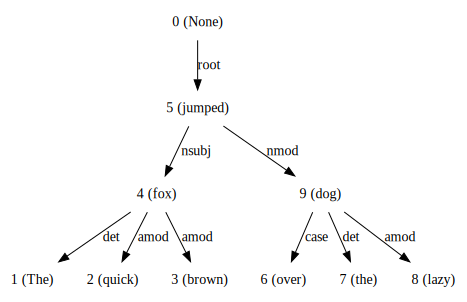

In [43]:
try:
    secondSentGraph = graphviz.Source(secondSentDepParseTree.to_dot())
except:
    secondSentGraph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
secondSentGraph

Or another sentence 

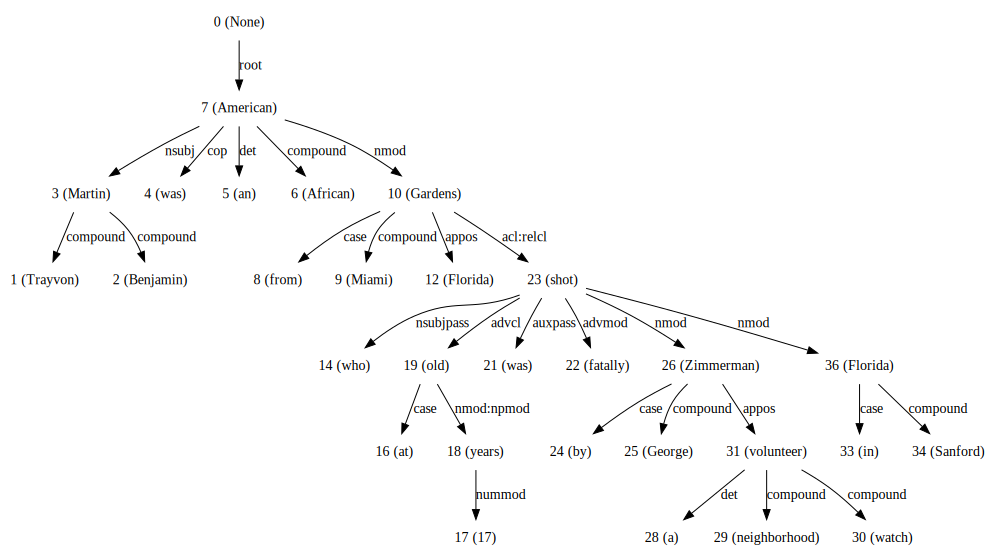

In [44]:
try:
    graph = graphviz.Source(list(depParses[3])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph

We can also do a dependency parse on the reddit sentences:

In [45]:
topPostDepParse = list(stanford.depParser.parse_sents(redditTopScores['sentences'][0]))

This takes a few seconds, but now lets look at the parse tree from one of the processed sentences.

The sentence is:

In [46]:
targetSentence = 7
print(' '.join(redditTopScores['sentences'][0][targetSentence]))

So anyway , I get a call from an older gentleman who 's quite bitter and mean right off the bat ( does n't like that I asked for his address / telephone number to verify the account , hates that he has to speak with a machine before reaching an agent , etc . ) .


Which leads to a very rich dependancy tree:

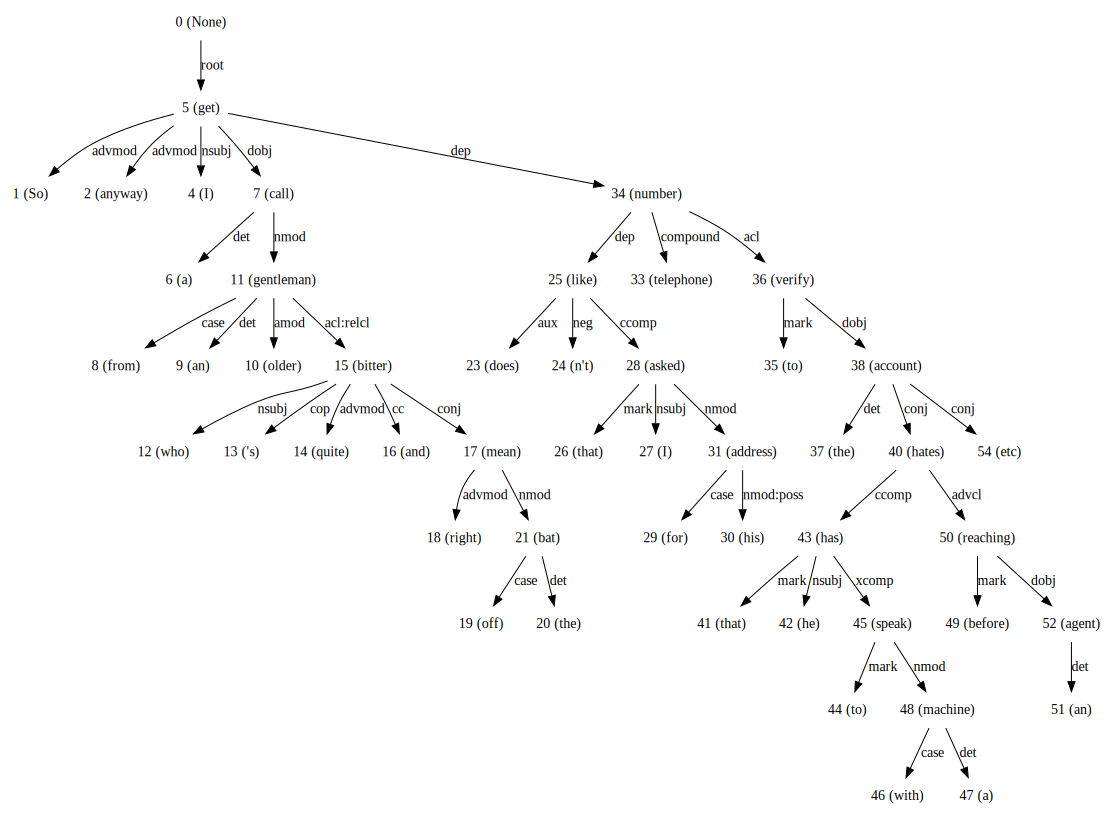

In [47]:
try:
    graph = graphviz.Source(list(topPostDepParse[targetSentence])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph


## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceived to play in the social world inscribed by your texts?

In [145]:
topPostDepParse = list(stanford.depParser.parse_sents(pubmedRecent['sentences'][8]))

The sentence is:

In [146]:
targetSentence = 1
print(' '.join(pubmedRecent['sentences'][8][targetSentence]))

Behavioral evidence shows that conflict control occurs over successive trials as well as longer time scales of trial blocks , but the relation among time scales as well as their neural mechanisms are unclear .


Which leads to a very rich dependancy tree:

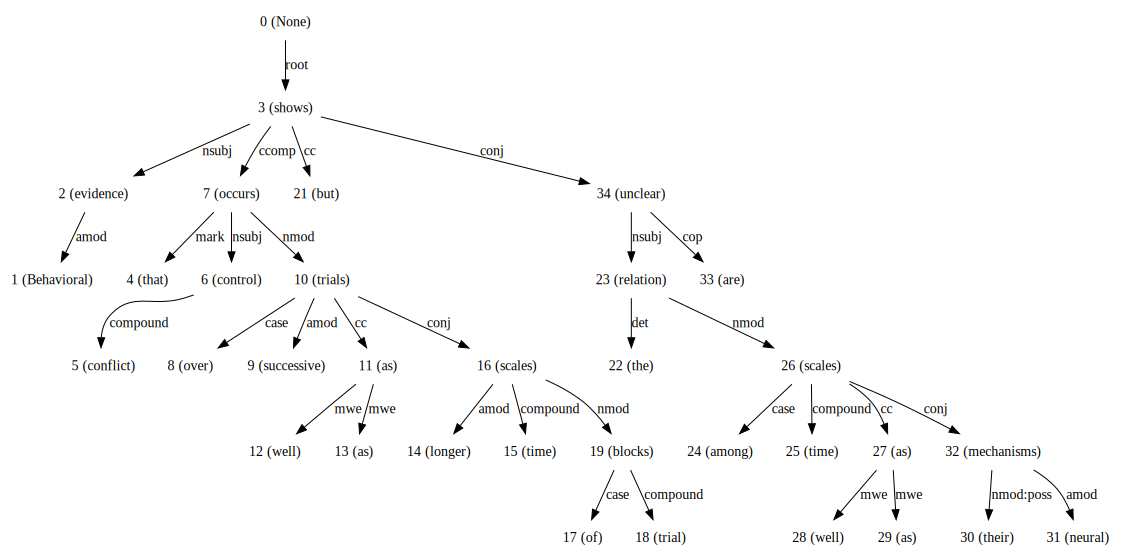

In [147]:
try:
    graph = graphviz.Source(list(topPostDepParse[targetSentence])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph


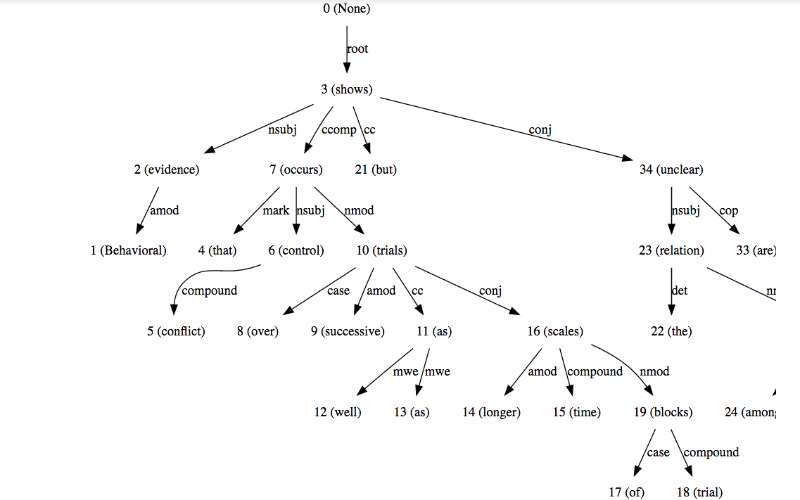

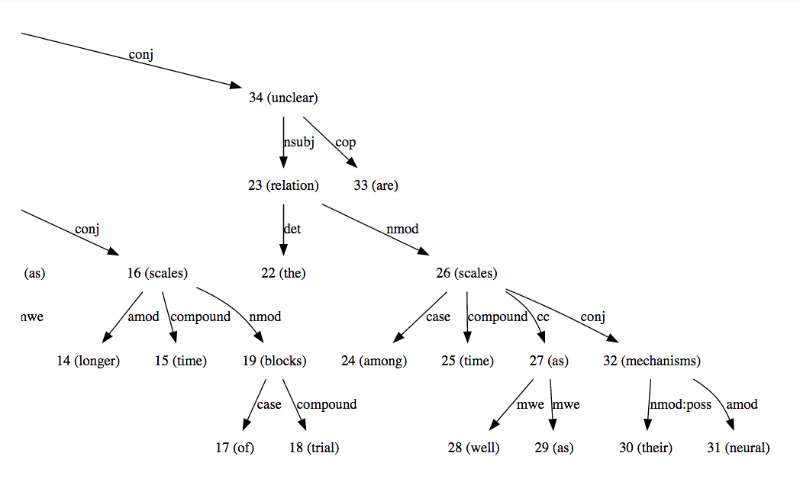

Here I took one sentence from one of the abstracts. The deeper it parses, the more complex a sentence will be. From the structure above, it is not very complex. And we could identify some key components of the sentence, which are about some evidence, a control occurs in two situations and some relations are unclear. 

Some things to extract from the parses: the adj behavioral modify the noun evidence, which shows that it is about some evidence related to behaviors; there is also a similar case that successive as an adj modify the noun trials to describe what kind of trials; following by the conjunction "as well as", there is a noun phrase, where time as a noun modify scales, and longer as an adj modify time; there are similar cases for adj or noun modify nouns in "time scales" and "neural mechanisms" in the second sentences.

The structure is good at identify key concepts conveying in this sentence, which is about evidence showing something and some relations remain unclear.

# Information extraction

Information extraction approaches typically (as here, with Stanford's Open IE engine) ride atop the dependency parse of a sentence. They are a pre-coded example of the type analyzed in the prior. 

In [166]:
ieDF = stanford.openIE(text)

Starting OpenIE run
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator pos
[main] INFO edu.stanford.nlp.tagger.maxent.MaxentTagger - Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [1.8 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator depparse
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
[main] INFO edu.stanford.nlp.parser.nndep.Classifier - PreComputed 99996, Elapsed Time: 21.28 (s)
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Initializing dependency parser ... done [23.1 sec].
[main] INFO edu.stanford.nlp.pipe

`openIE()` prints everything stanford core produces and we can see from looking at it that initializing the dependency parser takes most of the time, so calling the function will always take at least 12 seconds.

In [167]:
ieDF

,certainty,subject,verb,object
0,1.0,elephant,is in,my pajamas
1,1.0,I,saw,elephant in my pajamas
2,1.0,I,saw,elephant
3,1.0,quick brown fox,jumped over,lazy dog
4,1.0,quick brown fox,jumped over,dog
5,1.0,quick fox,jumped over,dog
6,1.0,fox,jumped over,dog
7,1.0,brown fox,jumped over,lazy dog
8,1.0,brown fox,jumped over,dog
9,1.0,quick fox,jumped over,lazy dog


No buffalos (because there were no verbs), but the rest is somewhat promising. Note, however, that it abandoned the key theme of the sentence about the tragic Trayvon Martin death ("fatally shot"), likely because it was buried so deeply within the complex phrase structure. This is obviously a challenge. 

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">How would you extract relevant information about the Trayvon Martin sentence directly from the dependency parse (above)? Code an example here. (For instance, what compound nouns show up with what verb phrases within the sentence?) How could these approaches inform your research project?

In [168]:
ieDF['subject'].value_counts()

Christine Lagarde              11
Trayvon Benjamin Martin         4
quick brown fox                 2
brown fox                       2
fox                             2
quick fox                       2
I                               2
Martin                          1
recent interview                1
short-term stimulus efforts     1
elephant                        1
Name: subject, dtype: int64

In [173]:
ieDF[ieDF['subject'] == 'Trayvon Benjamin Martin']['verb'].value_counts()

was                          2
was American from            1
was African American from    1
Name: verb, dtype: int64

In [174]:
ieDF[ieDF['subject'] == 'Trayvon Benjamin Martin']['object'].value_counts()

Florida             2
African American    1
American            1
Name: object, dtype: int64

In [169]:
ieDF[ieDF['subject'] == 'Christine Lagarde']['verb'].value_counts()

discussed                        10
discussed stimulus efforts in     1
Name: verb, dtype: int64

In [170]:
ieDF[ieDF['subject'] == 'Christine Lagarde']['object'].value_counts()

short-term stimulus efforts in interview with Wall Street Journal           1
short-term stimulus efforts in interview                                    1
short-term stimulus efforts in recent interview with Wall Street Journal    1
stimulus efforts in interview with Wall Street Journal                      1
stimulus efforts in interview                                               1
short-term stimulus efforts                                                 1
short-term stimulus efforts in recent interview                             1
stimulus efforts in recent interview                                        1
stimulus efforts                                                            1
France                                                                      1
stimulus efforts in recent interview with Wall Street Journal               1
Name: object, dtype: int64

What we could get from above is that Trayvon Benjamin Martin is African American, and probably from Florida or related to Florida. And Christine Lagarde is more about the interview with Wall Street Journal.

my project on pubmed

In [175]:
ieDF_pm8 = stanford.openIE(pubmedRecent['abstract'][8])

Starting OpenIE run
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator pos
[main] INFO edu.stanford.nlp.tagger.maxent.MaxentTagger - Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [1.9 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator depparse
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
[main] INFO edu.stanford.nlp.parser.nndep.Classifier - PreComputed 99996, Elapsed Time: 20.873 (s)
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Initializing dependency parser ... done [23.0 sec].
[main] INFO edu.stanford.nlp.pip

In [176]:
ieDF_pm8

,certainty,subject,verb,object
0,1.0,Cognitive control,is basic skill,vital for goal-oriented behavior
1,1.0,control,is skill,vital for behavior
2,1.0,control,is basic skill,vital
3,1.0,Cognitive control,is in,conflict situations
4,1.0,control,is skill,vital
5,1.0,control,is basic skill,vital for behavior
6,1.0,control,is basic skill,vital for goal-oriented behavior
7,1.0,Cognitive control,is skill,vital for behavior
8,1.0,control,is,basic
9,1.0,Cognitive control,is basic skill,vital


In [177]:
ieDF_pm8['subject'].value_counts()

Cognitive control                   7
control                             7
EEG data                            4
base rate                           3
Young adults                        2
Reaction time measures              2
conflict control                    2
base rate manipulation              2
study                               2
Two fronto-medial ICA components    1
relation                            1
evoked potentials                   1
Name: subject, dtype: int64

In [178]:
ieDF_pm8[ieDF_pm8['subject'] == 'Cognitive control']['verb'].value_counts()

is skill          3
is basic skill    3
is in             1
Name: verb, dtype: int64

In [179]:
ieDF_pm8[ieDF_pm8['subject'] == 'Cognitive control']['object'].value_counts()

vital                               2
vital for behavior                  2
vital for goal-oriented behavior    2
conflict situations                 1
Name: object, dtype: int64

What I got from one of the abstracts is about cognitive control, which is a basic skill (as described in the abstract), and is vital for goal-oriented behavior and in conflict situations.

And we can also look for subject, object, target triples in one of the reddit stories.

In [50]:
ieDF = stanford.openIE(redditTopScores['text'][0])

Starting OpenIE run
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator pos
[main] INFO edu.stanford.nlp.tagger.maxent.MaxentTagger - Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [1.7 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator depparse
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
[main] INFO edu.stanford.nlp.parser.nndep.Classifier - PreComputed 99996, Elapsed Time: 19.492 (s)
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Initializing dependency parser ... done [21.4 sec].
[main] INFO edu.stanford.nlp.pip

In [51]:
ieDF

,certainty,subject,verb,object
0,1.000000,we,'ll get,calls
1,1.000000,we,Quite often 'll get,calls
2,1.000000,we,often 'll get,calls
3,0.831036,we,coax,direct to TV
4,0.774359,straight analog cable,coax,direct from wall
5,0.774359,analog cable,coax,direct from wall to TV
6,0.774359,straight analog cable,coax,direct to TV
7,1.000000,we,would supply analog cable to,homes
8,0.831036,we,coax,direct from wall
9,0.774359,analog cable,coax,direct from wall


That's almost 200 triples in only:

In [52]:
len(redditTopScores['sentences'][0])

37

sentences and

In [53]:
sum([len(s) for s in redditTopScores['sentences'][0]])

971

words.

Lets find at the most common subject in this story.

In [54]:
ieDF['subject'].value_counts()

I                        48
it                       42
he                       19
He                       18
we                       11
man                       8
old man                   8
our booking calendar      4
letter                    4
call                      4
analog cable              4
straight analog cable     4
my supervisor             3
his TV set                2
TV                        2
you                       2
they                      2
people                    1
me                        1
our digital equipment     1
handling                  1
our equipment             1
repeat offenders          1
Name: subject, dtype: int64

I is followed by various male pronouns and compound nouns (e.g., "old man"). 'I' occures most often with the following verbs:

In [55]:
ieDF[ieDF['subject'] == 'I']['verb'].value_counts()

could come                        8
brought                           5
even brought                      5
had                               4
was                               4
speak for                         3
still think occasionally about    1
eventually had                    1
felt                              1
think about                       1
ask                               1
complaint in                      1
anyway get                        1
speak with                        1
took                              1
think occasionally about          1
get to                            1
've dealt with                    1
So anyway get                     1
have                              1
had cable within                  1
instantly felt                    1
do                                1
get                               1
still think about                 1
Name: verb, dtype: int64

and the following objects

In [56]:
ieDF[ieDF['subject'] == 'I']['object'].value_counts()

Mr. Smith                                             4
him                                                   3
call                                                  3
simplified remote                                     2
simplified remote for his set top box                 2
this                                                  2
remote for his set top box                            2
bad                                                   2
remote                                                2
get                                                   2
willing                                               2
her                                                   1
bit                                                   1
it                                                    1
cable                                                 1
speak with her for bit                                1
cable running                                         1
speak                                           

We can also run the corenlp server. When you run this server (with the command below), you can click on the browswer link provided to experiment with it. Note that when we run the server, executing the command below, it interrupts the current jupyter process and you will not be able to run code here again (processes will "hang" and never finish) until you interrup the process by clicking "Kernel" and then "Interrupt".

In [ ]:
stanford.startCoreServer()

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform open information extraction on a modest subset of texts relevant to your final project. Analyze the relative attachment of several subjects relative to verbs and objects and visa versa. Describe how you would select among these statements to create a database of high-value statements for your project and then do it by extracting relevant statements into a pandas dataframe.

Here I picked another abstract as an example

In [130]:
len(pubmedRecent['sentences'][15])

10

sentences and

In [131]:
sum([len(s) for s in pubmedRecent['sentences'][15]])

224

words.

In [132]:
ieDF_pm15 = stanford.openIE(pubmedRecent['abstract'][15])

Starting OpenIE run
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator pos
[main] INFO edu.stanford.nlp.tagger.maxent.MaxentTagger - Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [1.8 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator depparse
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
[main] INFO edu.stanford.nlp.parser.nndep.Classifier - PreComputed 99996, Elapsed Time: 20.578 (s)
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Initializing dependency parser ... done [22.3 sec].
[main] INFO edu.stanford.nlp.pip

In [133]:
ieDF_pm15

,certainty,subject,verb,object
0,1.000000,behaviors,may modify relationships among,diverse older adults
1,1.000000,Unhealthy behaviors,may modify relationships among,older adults
2,1.000000,Unhealthy behaviors,may modify relationships among,diverse older adults
3,1.000000,Unhealthy behaviors,may modify relationships among,diverse adults
4,1.000000,behaviors,may modify relationships among,older adults
5,1.000000,Unhealthy behaviors,may modify,relationships between stress
6,1.000000,behaviors,may modify,relationships between chronic stress
7,1.000000,Unhealthy behaviors,may modify,relationships
8,1.000000,behaviors,may modify,relationships
9,1.000000,behaviors,may modify,relationships between stress


the most common subject

In [191]:
ieDF_pm15['subject'].value_counts()[:10]

We                     18
behaviors              15
Unhealthy behaviors    15
indicating              4
most                    4
load                    2
Depressive disorder     2
disorder                2
Allostatic load         2
logistic regression     1
Name: subject, dtype: int64

verbs and objects following behaviors

In [136]:
ieDF_pm15[ieDF_pm15['subject'] == 'behaviors']['verb'].value_counts()

included                          8
may modify relationships among    4
may modify                        3
Name: verb, dtype: int64

In [193]:
ieDF_pm15[ieDF_pm15['subject'] == 'behaviors']['object'].value_counts()

fair/poor diet                          1
smoking                                 1
insufficient activity                   1
diverse older adults                    1
relationships between stress            1
insufficient physical activity          1
current smoking                         1
physical activity                       1
diverse adults                          1
adults                                  1
activity                                1
excessive/binge drinking                1
older adults                            1
relationships between chronic stress    1
relationships                           1
Name: object, dtype: int64

verbs and objects following We

In [187]:
ieDF_pm15[ieDF_pm15['subject'] == 'We']['verb'].value_counts()

analyzed    18
Name: verb, dtype: int64

and the following objects

In [186]:
ieDF_pm15[ieDF_pm15['subject'] == 'We']['object'].value_counts()

nationally representative data from participants                         1
nationally representative data from participants aged                    1
representative cross-sectional data from participants aged               1
representative data from participants                                    1
representative cross-sectional data from participants                    1
nationally representative cross-sectional data from participants         1
representative data from participants aged                               1
data from participants                                                   1
representative data                                                      1
nationally representative data                                           1
cross-sectional data from participants                                   1
cross-sectional data from participants aged                              1
data from participants aged                                              1
cross-sectional data     

For my case, I will the objects following the subjects are more important than the verbs. The following verbs do not actually tell any information about the subjects, but the objects tell a lot about what they talk about the subjects. What I will probably do is take the top subjects and also their top related objects for each abstract and put them in a dataframe, which might be my database of high value statments. However, there is still a problem about filtering about meaningless top-frequent subjects, such as we, indicating, load and logistic regression.